In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.image import imread
from matplotlib.image import imsave

In [2]:
plt.set_cmap( 'gray' )


<Figure size 432x288 with 0 Axes>

In [3]:
def filter_in_freq_domain( originalImage, kernel_filter ):

    # get dimensions of the image
    M = originalImage.shape[ 0 ]
    N = originalImage.shape[ 1 ]

    # retrieve kernel shape
    m = kernel_filter.shape[0]
    n = kernel_filter.shape[1]

    # calculate amount of row/col of zeros to pad
    a = int(( m - 1 ) / 2) # 'a' amount of top & bottom padding
    b = int(( n - 1 ) / 2) # 'b' amount of left & right padding

    # Convert kernel & image to freq. domain
    H = np.fft.fft2( kernel_filter, ( M + 2 * a, N + 2 * b ) ) # kernel in freq. domain
    F = np.fft.fft2( originalImage, ( M + 2 * a, N + 2 * b ) ) # image in freq. domain

    # filtered image in freq. domain
    G = F * H

    # convert back to spatial domain
    g = np.real( np.fft.ifft2( G ) )

    return g

In [4]:
def gaussian_kernel_filter_1d( m, sd = 1 ):
   
    # since gauss-curve is symmetric
    # we compute only the left side and the mid value

    x = np.arange( int( -m/2 ), 1 )

    left_f = (1 / ( sd * np.sqrt( 2 * np.pi ) )) * np.exp( -x**2 / (2 * sd**2) )
    right_f = np.flip( left_f )          # flip the left side
    right_f = right_f[ 1: ]              # remove the mid value, bec. it appears twice
    f = np.hstack( [ left_f, right_f ] ) # stack left & right
    return f

def gaussian_kernel_filter_2d( sd = 1 ):

    m = np.ceil( 6 * sd ) + 1
    n = np.ceil( 6 * sd ) + 1

    # since 2D gaussian kernel is separable
    # we only need the outer product
    # of two 1D gaussian kernels
    v = gaussian_kernel_filter_1d( m, sd )
    w = np.outer( v, v )

    # normalize
    w = ( 1 / np.sum( w ) ) * w
    print( "Kernel shape: ", w.shape )
    
    return w

In [5]:
def sobel_operator_x():
    return np.array( [ -1, -2, -1, 0, 0, 0, 1, 2, 1 ] ).reshape( (3,3) )

def sobel_operator_y():
    return sobel_operator_x().T

def prewit_operator_x():
    return np.array( [ -1, -1, -1, 0, 0, 0, 1, 1, 1 ] ).reshape( (3,3) )

def prewit_operator_y():
    return prewit_operator_x().T

def get_magnitude( image, operator = 'sobel' ):

    if operator == 'sobel':
         gx = filter_in_freq_domain( image, sobel_operator_x() )
         gy = filter_in_freq_domain( image, sobel_operator_y() )
         return np.sqrt( np.square(gx) + np.square(gy) )
    elif operator == 'prewit':
        gx = filter_in_freq_domain( image, prewit_operator_x() )
        gy = filter_in_freq_domain( image, prewit_operator_y() )
        return np.sqrt( np.square(gx) + np.square(gy) )
    else:
        return np.sqrt( image**2 )

def get_alpha( image, operator = 'sobel' ):
    
    if operator == 'sobel':
         gx = filter_in_freq_domain( image, sobel_operator_x() )
         gy = filter_in_freq_domain( image, sobel_operator_y() )
    elif operator == 'prewit':
        gx = filter_in_freq_domain( image, prewit_operator_x() )
        gy = filter_in_freq_domain( image, prewit_operator_y() )
        
    return np.arctan( gy / gx )

In [6]:
def laplacian_kernel_filter():
    w = [ 1, 1, 1, 1, -8, 1, 1, 1, 1 ]
    return np.array( w ).reshape( 3,3 )

In [7]:
def laplacian_of_gaussian( sd = 1 ):
    gaussian = gaussian_kernel_filter_2d( sd )
    laplacian = laplacian_kernel_filter()
    w = filter_in_freq_domain( gaussian, laplacian )
    return w

In [8]:
def get_zero_crossing( image, threshold = 0 ):
    M, N = image.shape
    g = np.zeros_like( image )

    for x in range( 1, N-1 ):
        for y in range( 1, M-1 ):
            
            # 8 neighbors
            n  = image[ y - 1, x     ]
            s  = image[ y + 1, x     ]
            e  = image[ y    , x + 1 ]
            w  = image[ y    , x - 1 ]
            ne = image[ y - 1, x + 1 ]
            nw = image[ y - 1, x - 1 ]
            se = image[ y + 1, x + 1 ]
            sw = image[ y + 1, x - 1 ]

            # compare sign of opposing neigbors
            ud = np.sign( n  ) != np.sign( s  )
            rl = np.sign( e  ) != np.sign( w  )
            d1 = np.sign( nw ) != np.sign( se )
            d2 = np.sign( ne ) != np.sign( sw )
            
            # at least 2 neighbors must opposing signs
            cond1 = ud and rl or d1 and d2
            cond2 = ud and d1 or rl and d2
            cond3 = ud and d2 or rl and d1

            # set white if one of the conditions is fulfilled
            if cond1 or cond2 or cond3:
                
                # control whether the abs. value difference
                # between opposing neighbors exceed the given threshold
                rl = abs( e  - w  ) > threshold
                ud = abs( n  - s  ) > threshold
                d1 = abs( nw - se ) > threshold
                d2 = abs( ne - sw ) > threshold
                
                if rl and ud or d1 and d2:
                    g[ y, x ] = 1
                
    return g

## Marr-Hildreth Algorithm

In [9]:
lena = imread('lena512.jpg')

Kernel shape:  (13, 13)
Kernel shape:  (25, 25)
Kernel shape:  (37, 37)


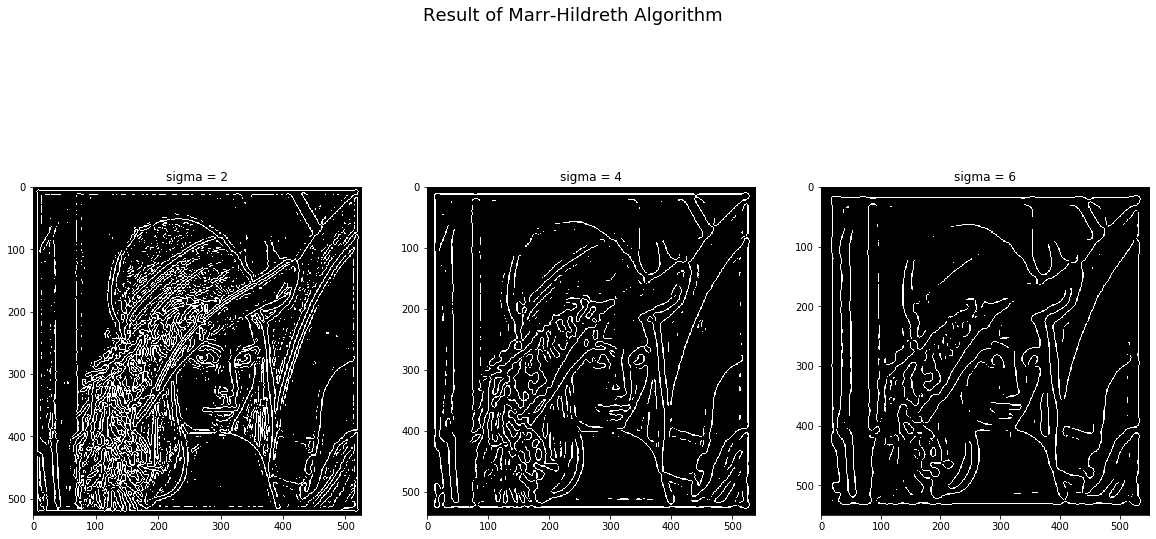

In [10]:
fig, axes = plt.subplots( 1, 3, figsize= (20, 10) )
fig.suptitle( "Result of Marr-Hildreth Algorithm", fontsize = 18 )

images = []
sds = [ 2, 4, 6 ]

for i, sd in zip( range(3), sds ):
    lena_lap_of_gaus = filter_in_freq_domain( lena, laplacian_of_gaussian( sd ) ) # laplacian of gaussian of lena
    t = 0.04 * np.max( lena_lap_of_gaus )                                         # threshold
    lena_zero_cross = get_zero_crossing( lena_lap_of_gaus, t )                    # zero-crossing detection of lena_LoG
    images.append( lena_zero_cross )

titles = [ "sigma = 2", "sigma = 4", "sigma = 6" ]

for ax, im, title in zip( axes, images, titles ):
    ax.imshow(im)
    ax.set_title(title)

fig.savefig( 'marr-hildreth-lena.png' )

## Canny Edge Detection

In [11]:
def get_nonmaxima_supressed( image_magnitude, image_alpha ):

    M, N = image_magnitude.shape

    # convert to degrees
    image_alpha = image_alpha * 180 / np.pi

    # convert to 0 - 180 degrees
    image_alpha[ image_alpha < 0 ] += 180

    g = np.zeros_like( image_magnitude )

    for y in range( 1, M - 1 ):
        for x in range( 1, N - 1 ):
            
            K = image_magnitude[ y, x ]
            d = image_alpha[ y, x ]

            # horizontal edge
            if ( 0 <= d < 22.5 ) or ( 157.5 <= d <= 180 ):
                n1 = image_magnitude[ y, x + 1 ] # east neighbor
                n2 = image_magnitude[ y, x - 1 ] # west neighbor

            # -45 deg. edge
            elif 22.5 <= d < 67.5:
                n1 = image_magnitude[ y + 1, x - 1 ] # south west neighbor
                n2 = image_magnitude[ y - 1, x + 1 ] # north east neighbor

            # vertical edge
            elif 67.5 <= d < 112.5:
                n1 = image_magnitude[ y + 1, x ] # south neighbor
                n2 = image_magnitude[ y - 1, x ] # north neighbor

            # 45 deg. edge
            elif 112.5 <= d < 157.5:
                n1 = image_magnitude[ y - 1, x - 1 ] # nort west neighbor
                n2 = image_magnitude[ y + 1, x + 1 ] # south east neighbor

            # max value 
            else: 
                n1 = 255
                n2 = 255

            # if current pixel is greater than
            # both of its neighbors, then 
            # assign K at the supressed image
            if K >= n1 and K >= n2:
                g[ y, x ] = K

    return g

In [12]:
def apply_double_threshold( image, low_threshold_ratio = 0.1, high_threshold_ratio = 0.2 ):

    high_threshold = image.max() * high_threshold_ratio
    low_threshold  = image.max() * low_threshold_ratio

    g = np.zeros_like( image )

    strong_y, strong_x = np.where( image >= high_threshold ) # strong pixels
    weak_y, weak_x = np.where( (image <= high_threshold) & (image >= low_threshold) ) # weak pixels ( in between )

    g[ strong_y, strong_x ] = 255
    g[ weak_y, weak_x ] = 25

    return g

In [13]:
def apply_hysteresis( image ):
   
    M, N = image.shape

    strong_intensity = 255
    weak_intensity = 25

    for y in range( 1, M - 1 ):
        for x in range( 1, N - 1 ):
            
            if image[ y, x ] == weak_intensity:

                # 8 neighbors
                n  = image[ y - 1, x     ]
                s  = image[ y + 1, x     ]
                e  = image[ y    , x + 1 ]
                w  = image[ y    , x - 1 ]
                ne = image[ y - 1, x + 1 ]
                nw = image[ y - 1, x - 1 ]
                se = image[ y + 1, x + 1 ]
                sw = image[ y + 1, x - 1 ]

                if (
                    ( n  == strong_intensity ) or ( s  == strong_intensity ) or
                    ( e  == strong_intensity ) or ( w  == strong_intensity ) or
                    ( ne == strong_intensity ) or ( nw == strong_intensity ) or
                    ( se == strong_intensity ) or ( sw == strong_intensity )
                   ):
                   image[ y, x ] = strong_intensity
                else:
                    image[ y, x ] = 0
                  
    return image

Kernel shape:  (7, 7)
Kernel shape:  (13, 13)
Kernel shape:  (19, 19)


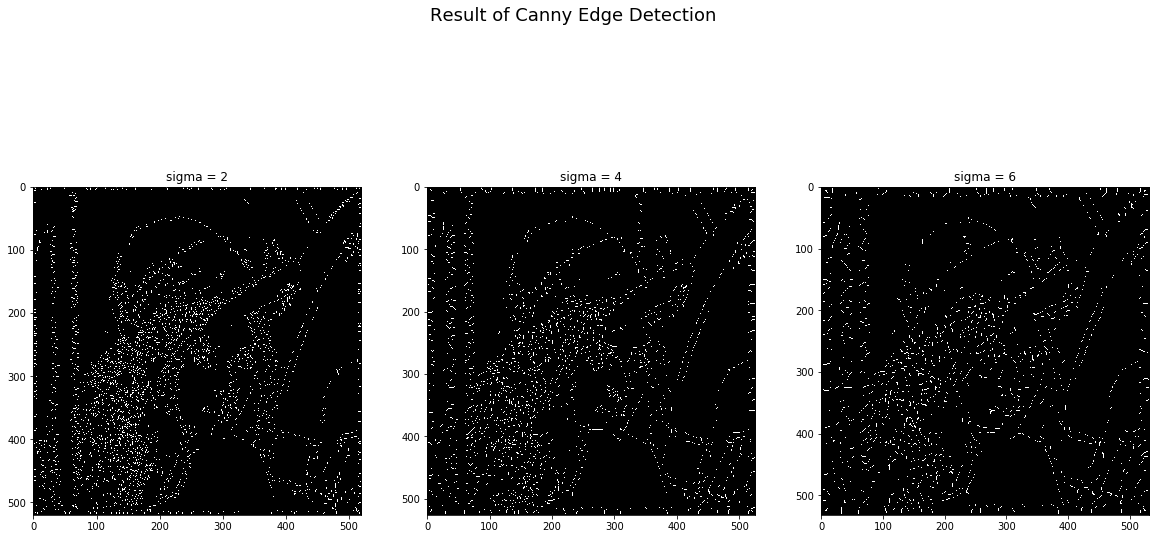

In [14]:
fig, axes = plt.subplots( 1, 3, figsize= (20, 10) )
fig.suptitle( "Result of Canny Edge Detection", fontsize = 18 )

images = []
sds = [ 1, 2, 3 ]

for i, sd in zip( range(3), sds ):
    lena_smoothed = filter_in_freq_domain( lena, gaussian_kernel_filter_2d( sd ) )
    lena_mag = get_magnitude( lena_smoothed, 'sobel' )
    lena_alpha = get_alpha( lena_smoothed, 'sobel' )
    lena_nonmaxima_supressed = get_nonmaxima_supressed( lena_mag, lena_alpha )
    lena_double_thresholded = apply_double_threshold( lena_nonmaxima_supressed, 0.04, 0.08 )
    lena_hysterisis = apply_hysteresis( lena_double_thresholded )
    images.append( lena_hysterisis )

titles = [ "sigma = 2", "sigma = 4", "sigma = 6" ]

for ax, im, title in zip( axes, images, titles ):
    ax.imshow(im)
    ax.set_title(title)

fig.savefig( 'canny-edge-lena.png' )